In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and preprocess data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data

path_dataset = "../data/data_train.csv"
#path_dataset = "../data/movielens100k.csv"
#subsample = [100, 200]
#ratings = load_data(path_dataset,subsample)
ratings = load_data(path_dataset)
print(ratings.shape)

number of items: 10000, number of users: 1000
(10000, 1000)


### Plot the number of ratings per movie and user

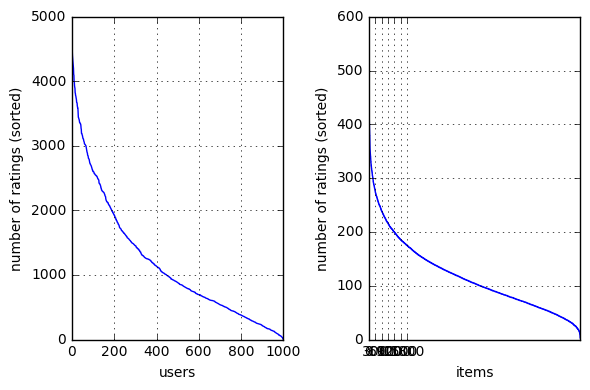

In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

Percentage of nz train data:  0.8998, percentage of nz test data:  0.1002


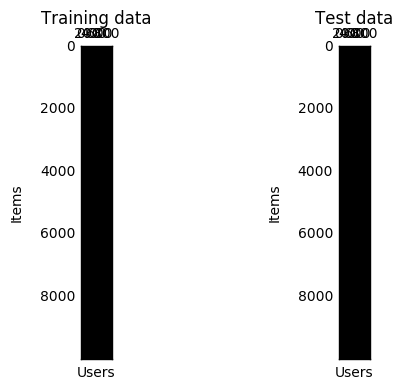

In [6]:
from plots import plot_train_test_data
from our_helpers import split_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

    ## Apply baselines

In [85]:
from our_helpers import compute_error2
from helpers import build_index_groups
from data_preprocess import get_user_means, get_item_means, get_global_means, get_unbiased_matrix

scale = np.arange(0,6)
scale = np.vstack((scale,scale))
train = sp.lil_matrix((5,5))
train[0,3] = 4.0
train[0,1] = 4.0
train[0,4] = 5.0
train[1,3] = 1.0
train[1,2] = 2.0
train[1,4] = 3.0
train[2,0] = 3.0
train[2,3] = 3.0
train[3,0] = 4.0
train[3,1] = 3.0
train[4,3] = 1.0
train[4,2] = 1.0
test = sp.lil_matrix((5,5))
test[0,2] = 1.0 
test[0,0] = 3.0
test[1,1] = 2.0 
test[1,0] = 4.0
test[2,4] = 2.0 
test[2,2] = 2.0 
test[3,2] = 1.0 
test[3,4] = 3.0 
test[4,0] = 2.0
test[4,4] = 1.0 

global ok
error: 2.83333333333
user ok
error: 2.96858552176
item ok
error: 3.0663949155
combined ok
error: 3.36753289186
no method ok
error: 0.0


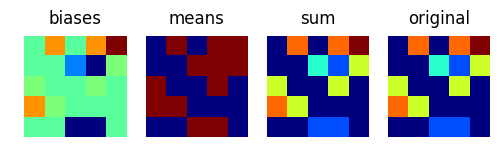

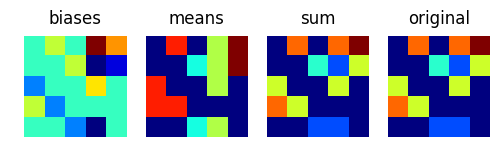

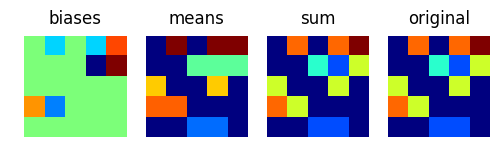

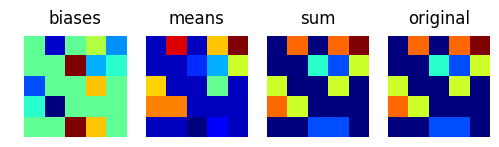

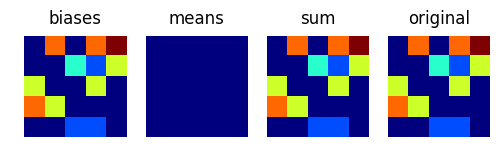

In [87]:
methods=['global','user','item','combined','no']
nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)
user_means = get_user_means(train, nz_col_rowindices) 
item_means = get_item_means(train, nz_row_colindices)
means = get_global_means(train, nz_train) 
for m in methods:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    train_normalized, train_mean = get_unbiased_matrix(train.copy(),user_means,item_means,means,m)
    print('error:',np.sqrt(compute_error2(train_mean,test,zip(rows,cols))))
    #print('normalized',train_normalized.todense())
    #print('mean',train_mean.todense())
    #print('original',(train_normalized+train_mean).todense())
    plt.title('test')
    ax1.set_title('biases')
    ax1.matshow(train_normalized.todense())
    ax1.axis('off')
    ax2.set_title('means')
    ax2.matshow(train_mean.todense())
    ax2.axis('off')
    ax3.set_title('sum')
    ax3.matshow((train_normalized+train_mean).todense())
    ax3.axis('off')
    ax4.set_title('original')
    ax4.matshow(train.todense())
    ax4.axis('off')
    fig.savefig('../results/biases_{}'.format(m))


## Cross validation of methods

global ok
2.83333333333
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 4.940205914875899.
iter: 1, RMSE on training set: 4.930994111198865.
iter: 2, RMSE on training set: 4.923345567995744.
iter: 3, RMSE on training set: 4.91699109381253.
iter: 4, RMSE on training set: 4.9117090494450615.
iter: 5, RMSE on training set: 4.907316582546383.
iter: 6, RMSE on training set: 4.903662587918576.
iter: 7, RMSE on training set: 4.900622021490263.
iter: 8, RMSE on training set: 4.898091285261534.
iter: 9, RMSE on training set: 4.89598446591587.
iter: 10, RMSE on training set: 4.894230258356597.
iter: 11, RMSE on training set: 4.892769441911914.
iter: 12, RMSE on training set: 4.89155280468446.
iter: 13, RMSE on training set: 4.890539432825503.
iter: 14, RMSE on training set: 4.8896952980419774.
iter: 15, RMSE on training set: 4.8889920895838195.
iter: 16, RMSE on training set: 4.888406247171583.
iter: 17, RMSE on training set: 4.887918159444461.
iter: 18, RMSE on traini

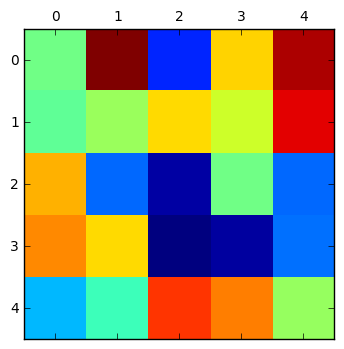

In [66]:
from optimization_sgd import matrix_factorization_sgd, compute_error

gamma = 0.0001 #0.0002 with K=20 worked well
num_features = 20 # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
num_epochs = 20 # number of full passes through the train set

# Noramlize data before doing tests.
methods=['global']
for m in methods:
    train_normalized, train_mean = get_normalized_matrix(train.copy(),m)
    user_features_train, item_features_train = matrix_factorization_sgd(train_normalized, gamma, num_features, \
                                                                            lambda_user, lambda_item, num_epochs)
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    train_prediction = np.dot(item_features_train.T, user_features_train) + train_mean
    plt.matshow(train_prediction)
    rmse = compute_error2(test, train_prediction, nz_test)
    print("RMSE on test data with {} normalization: {}.".format(m, rmse))

In [ ]:
from optimization_sgd import matrix_factorization_bsgd, compute_error

## Create Submission

In [15]:
from optimization_sgd import matrix_factorization_sgd, compute_error

gamma = 0.0001
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
num_epochs = 1     # number of full passes through the train set
user_features, item_features = matrix_factorization_sgd(ratings, gamma, num_features, lambda_user, lambda_item, num_epochs)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.3978255190467372.


## Analyze results

In [15]:
from optimization_sgd import matrix_factorization_sgd, compute_error

gamma = 0.0001
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
num_epochs = 1     # number of full passes through the train set
user_features, item_features = matrix_factorization_sgd(ratings, gamma, num_features, lambda_user, lambda_item, num_epochs)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.3978255190467372.


In [16]:
ratings_full = np.dot(item_features.T,user_features)
print(ratings_full.shape)
print(ratings.shape)

(10000, 1000)
(10000, 1000)


In [18]:
from our_helpers import create_submission
path_output = "../results/submission.csv"
create_submission(path_output, ratings_full)

number of items: 10000, number of users: 1000
